## Project Overview

This project implements a **CycleGAN-based image-to-image translation model** to transform real-world photographs into **Monet-style paintings** using the **Kaggle GAN Getting Started (Monet Painting Dataset)**. The dataset contains Monet paintings and real photos in both JPG and TFRecord formats.

The workflow includes:
1. **Exploratory Data Analysis (EDA)** – inspecting dataset composition, image dimensions, and visual samples.
2. **Model Design & Training** – building a ResNet-based generator and PatchGAN discriminator with adversarial, cycle-consistency, and identity losses.
3. **Evaluation & Submission** – generating Monet-style images from real photos, submitting results to Kaggle for **MiFID** scoring, and recording leaderboard position.

This project fulfills Coursera Week 5 GAN mini-project requirements by delivering:
- A Jupyter Notebook with problem description, methodology, results, and discussion.
- A public GitHub repository containing source code and notebooks.
- A screenshot of the Kaggle competition leaderboard showing the model’s performance.

## Step 1 — Exploratory Data Analysis (EDA)

In this step, we explore the **Kaggle Monet Painting Dataset** to understand its composition and characteristics before building the GAN model. The dataset contains two main domains:

- **Monet paintings** (`monet_jpg/`, `monet_tfrecord/`)
- **Real-world photos** (`photo_jpg/`, `photo_tfrecord/`)

### Objectives
1. **Count the number of images** in each domain.
2. **Inspect image dimensions** to determine preprocessing requirements.
3. **Visualize random samples** from both Monet paintings and real-world photos for qualitative comparison.
4. Prepare the dataset paths and constants for further model development.

### Expected Output
- A printed summary of dataset sizes.
- A brief observation of image resolutions.
- Side-by-side sample images from both domains.

In [1]:
# ---- MUST be the first cell ----
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"       
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"      
os.environ["TF_NUM_INTEROP_THREADS"] = "8"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"       

In [2]:
# Step 1.1 — Import Required Libraries

# General utilities
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualization
import seaborn as sns

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow settings
AUTO = tf.data.AUTOTUNE

print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TF version: 2.15.1
GPU devices: []


In [3]:
#  1.2 — Load Dataset Paths
DATA_PATH = r"D:/AI/CU-AI/Vicky/Class 3/W5"

monet_jpg_path = os.path.join(DATA_PATH, "monet_jpg")
photo_jpg_path = os.path.join(DATA_PATH, "photo_jpg")

# Step 3 — Display Dataset Info
monet_files = tf.io.gfile.listdir(monet_jpg_path)
photo_files = tf.io.gfile.listdir(photo_jpg_path)

print(f"Monet paintings: {len(monet_files)} images")
print(f"Real-world photos: {len(photo_files)} images")

# Step 4 — Preview a Few File Names
print("\nSample Monet files:", monet_files[:5])
print("Sample Photo files:", photo_files[:5])

Monet paintings: 300 images
Real-world photos: 7038 images

Sample Monet files: ['000c1e3bff.jpg', '011835cfbf.jpg', '0260d15306.jpg', '049e293b93.jpg', '05144e306f.jpg']
Sample Photo files: ['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg']


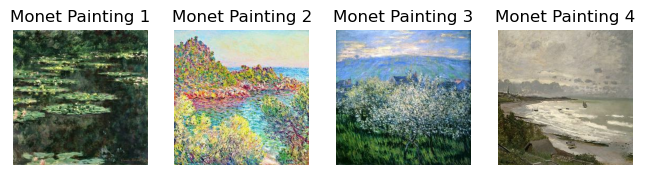

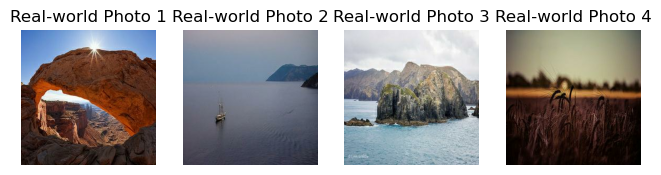

In [4]:
# Step 1.3 — Visualize Random Samples

def show_random_images(file_list, title, n=4):
    plt.figure(figsize=(8, 8))
    samples = random.sample(file_list, n)
    for i, fname in enumerate(samples):
        img_path = os.path.join(monet_jpg_path if 'monet' in title.lower() else photo_jpg_path, fname)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {i+1}")
    plt.show()

show_random_images(monet_files, "Monet Painting")
show_random_images(photo_files, "Real-world Photo")

## Step 2 — Model Design & Training

In this step, we design and implement a **CycleGAN** model to translate real-world photos into Monet-style paintings.

### Model Components
1. **Generator**  
   - Architecture: ResNet-based generator with downsampling, residual blocks, and upsampling layers.  
   - Normalization: Instance normalization to stabilize training and preserve style consistency.  
   - Activation: ReLU in generator, Tanh at the output layer.

2. **Discriminator**  
   - Architecture: 70×70 **PatchGAN** discriminator.  
   - Purpose: Classifies overlapping patches as real or fake to encourage high-frequency detail in generated images.

3. **Loss Functions**  
   - **Adversarial Loss**: Encourages generated images to be indistinguishable from target domain images.  
   - **Cycle-Consistency Loss**: Enforces mapping back to the original domain with minimal reconstruction error.  
   - **Identity Loss**: Preserves color and lighting when mapping an image already in the target domain.

4. **Training Setup**  
   - Optimizer: Adam with learning rate scheduling (initial constant phase followed by linear decay).  
   - Mixed precision training (optional) for performance improvement.  
   - Training on paired batches from both domains.

### Expected Output
- A compiled CycleGAN model ready for training.
- Training logs showing loss curves for generators and discriminators.
- Intermediate generated samples at regular intervals to track style transfer quality.

## Step 2-1 — Model Design & Training (CycleGAN)

We implement:
- **Generators** \(G\_{X→Y}, G\_{Y→X}\): ResNet-based with 9 residual blocks, instance normalization, `tanh` output.
- **Discriminators** \(D\_X, D\_Y\): 70×70 PatchGAN.
- **Losses**: adversarial (BCE w/ logits), cycle-consistency L1, identity L1.
- **Optimizers**: Adam with TTUR (G:2e-4, D:1e-4), β1=0.5, β2=0.999.
- **Training**: unpaired batches from `photo_jpg` (X) and `monet_jpg` (Y); save sample images each epoch.


In [5]:
# ==== 2.0 Hyperparams & helpers (CPU-friendly) ====
import os, random, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
AUTO = tf.data.AUTOTUNE
print("TF:", tf.__version__)

# Image & batch
IMG_SIZE = 256
BATCH    = 1

# TTUR learning rates
LR_G = 2e-4          # generator
LR_D = 1e-4          # discriminator (lower for stability)

# CycleGAN loss weights
LAMBDA_CYC = 10.0
LAMBDA_ID  = 5.0

# Local paths (change if needed)
DATA_PATH = r"D:/AI/CU-AI/Vicky/Class 3/W5"
photo_jpg_path = os.path.join(DATA_PATH, "photo_jpg")
monet_jpg_path = os.path.join(DATA_PATH, "monet_jpg")

def decode_resize_norm(path):
    """Decode JPEG → flip → jitter(resize+crop) → [-1,1]."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_flip_left_right(img)
    side = IMG_SIZE + 30
    img = tf.image.resize(img, (side, side), method='bicubic')
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    return (tf.cast(img, tf.float32)/127.5) - 1.0

def make_ds_subset(dir_path, limit=None, shuffle=True):
    files = tf.io.gfile.listdir(dir_path)
    if limit: files = files[:limit]
    paths = [os.path.join(dir_path, f) for f in files]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle: ds = ds.shuffle(len(paths), seed=42)
    ds = ds.map(decode_resize_norm, num_parallel_calls=AUTO)
    return ds.batch(BATCH, drop_remainder=True).prefetch(AUTO)

TF: 2.15.1


In [6]:
# ==== 2.1 Models: ResNet Generator & 70x70 PatchGAN ====
from tensorflow.keras import layers as L, Model

def InstanceNorm():
    return L.LayerNormalization(axis=[1,2], epsilon=1e-5)

def res_block(x, ch):
    y = L.Conv2D(ch, 3, padding='same')(x); y = InstanceNorm()(y); y = L.ReLU()(y)
    y = L.Conv2D(ch, 3, padding='same')(y); y = InstanceNorm()(y)
    return L.Add()([x, y])

def build_generator(n_res=None):
    if n_res is None:
        n_res = 9 if IMG_SIZE >= 256 else 6
    inp = L.Input((IMG_SIZE, IMG_SIZE, 3))
    x = L.Conv2D(64, 7, padding='same')(inp); x = InstanceNorm()(x); x = L.ReLU()(x)
    for ch in [128, 256]:
        x = L.Conv2D(ch, 3, strides=2, padding='same')(x); x = InstanceNorm()(x); x = L.ReLU()(x)
    for _ in range(n_res):
        x = res_block(x, 256)
    for ch in [128, 64]:
        x = L.Conv2DTranspose(ch, 3, strides=2, padding='same')(x); x = InstanceNorm()(x); x = L.ReLU()(x)
    out = L.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return Model(inp, out, name="Generator")

def build_discriminator():
    def block(x, ch, s):
        x = L.Conv2D(ch, 4, strides=s, padding='same')(x); x = L.LeakyReLU(0.2)(x)
        x = L.Conv2D(ch, 4, strides=1, padding='same')(x); x = InstanceNorm()(x); x = L.LeakyReLU(0.2)(x); 
        return x
    inp = L.Input((IMG_SIZE, IMG_SIZE, 3))
    x = block(inp, 64, 2)
    x = block(x, 128, 2)
    x = block(x, 256, 2)
    x = L.Conv2D(512, 4, padding='same')(x); x = InstanceNorm()(x); x = L.LeakyReLU(0.2)(x)
    out = L.Conv2D(1, 4, padding='same')(x)
    return Model(inp, out, name="Discriminator")


In [7]:
# ==== instantiate models (must run after definitions) ====
G_XY = build_generator()
G_YX = build_generator()
D_X  = build_discriminator()
D_Y  = build_discriminator()

# simple sanity prints
print("G_XY params:", G_XY.count_params())
print("G_YX params:", G_YX.count_params())
print("D_X  params:", D_X.count_params())
print("D_Y  params:", D_Y.count_params())



G_XY params: 11861507
G_YX params: 11861507
D_X  params: 4186497
D_Y  params: 4186497


In [8]:
# ==== 2.2 Losses & Train Step (stabilized) ====
optG = tf.keras.optimizers.Adam(LR_G, beta_1=0.5, beta_2=0.999)
optD = tf.keras.optimizers.Adam(LR_D, beta_1=0.5, beta_2=0.999)
bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def adv_loss(logits, is_real):
    logits = tf.cast(logits, tf.float32)
    y = tf.ones_like(logits)*0.9 if is_real else tf.zeros_like(logits)
    return bce(y, logits)

@tf.function
def train_step(x, y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y   = G_XY(x, training=True)
        fake_x   = G_YX(y, training=True)
        cycled_x = G_YX(fake_y, training=True)
        cycled_y = G_XY(fake_x, training=True)
        id_x     = G_YX(x, training=True)
        id_y     = G_XY(y, training=True)

        d_x_real = D_X(x, training=True); d_x_fake = D_X(fake_x, training=True)
        d_y_real = D_Y(y, training=True); d_y_fake = D_Y(fake_y, training=True)

        g_adv = adv_loss(d_y_fake, True) + adv_loss(d_x_fake, True)
        g_cyc = tf.reduce_mean(tf.abs(x - cycled_x)) + tf.reduce_mean(tf.abs(y - cycled_y))
        g_id  = tf.reduce_mean(tf.abs(x - id_x))     + tf.reduce_mean(tf.abs(y - id_y))
        G_loss = g_adv + LAMBDA_CYC * g_cyc + LAMBDA_ID * g_id

        D_loss = (adv_loss(d_x_real, True) + adv_loss(d_x_fake, False) +
                  adv_loss(d_y_real, True) + adv_loss(d_y_fake, False))

    g_vars = G_XY.trainable_variables + G_YX.trainable_variables
    d_vars = D_X.trainable_variables  + D_Y.trainable_variables
    optG.apply_gradients(zip(tape.gradient(G_loss, g_vars), g_vars))
    optD.apply_gradients(zip(tape.gradient(D_loss, d_vars), d_vars))
    return {"G": tf.reduce_mean(G_loss), "D": tf.reduce_mean(D_loss)}

def update_lr(epoch, total_epochs):
    """Linear decay in the second half of training."""
    if epoch > total_epochs // 2:
        frac = 1.0 - (epoch - total_epochs//2) / float(total_epochs - total_epochs//2)
        optG.learning_rate = LR_G * max(frac, 0.0)
        optD.learning_rate = LR_D * max(frac, 0.0)
    else:
        optG.learning_rate = LR_G
        optD.learning_rate = LR_D

## CPU Quick Run (no GPU) — get first results fast

- Downscale to **128×128** to cut compute.
- Use a **small subset** of the dataset.
- **3 epochs × 100 steps** per epoch.
- Save a sample each epoch.

In [9]:
# ==== dataset + training budget ====
EPOCHS, STEPS_PER_EPOCH = 4, 200
SUBSET_X, SUBSET_Y = 800, 800

ds_X = make_ds_subset(photo_jpg_path, SUBSET_X)
ds_Y = make_ds_subset(monet_jpg_path, SUBSET_Y)
train_ds = tf.data.Dataset.zip((ds_X, ds_Y))

# tiny assertion
sample_x = next(iter(ds_X.take(1)))
sample_y = next(iter(ds_Y.take(1)))
print("Sample batch shapes:", sample_x.shape, sample_y.shape)

Sample batch shapes: (1, 256, 256, 3) (1, 256, 256, 3)


In [10]:
# ==== quick forward/backward sanity ====
logs = train_step(sample_x, sample_y)
print("One train_step OK | G:", float(logs["G"]), "D:", float(logs["D"]))

One train_step OK | G: 23.600360870361328 D: 3.2381653785705566


In [11]:
# ==== training loop ====
import time, pathlib
SAMPLE_DIR = pathlib.Path("./outputs/samples_cpu"); SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    update_lr(ep, EPOCHS)

    it = iter(train_ds.repeat())
    g_hist, d_hist = [], []
    for step in range(1, STEPS_PER_EPOCH+1):
        xb, yb = next(it)
        logs = train_step(xb, yb)
        g_hist.append(float(logs["G"])); d_hist.append(float(logs["D"]))
        if step % 50 == 0 or step == 1 or step == STEPS_PER_EPOCH:
            print(f"Ep {ep}/{EPOCHS} Step {step:03d}/{STEPS_PER_EPOCH} "
                  f"G={np.mean(g_hist):.3f} D={np.mean(d_hist):.3f} "
                  f"| lrG={float(getattr(optG.learning_rate,'numpy',lambda:optG.learning_rate)()):.6f}", end="\r")

    # save preview
    gen = G_XY(sample_x, training=False)
    img = tf.clip_by_value((gen[0]+1.0)*127.5, 0, 255)
    tf.keras.utils.save_img(SAMPLE_DIR/f"epoch_{ep:03d}.png", tf.cast(img, tf.uint8))
    print(f"\nEpoch {ep} done in {time.time()-t0:.1f}s | "
          f"G={np.mean(g_hist):.3f} D={np.mean(d_hist):.3f}")

Ep 1/4 Step 200/200 G=11.578 D=2.645 | lrG=0.000200
Epoch 1 done in 2419.1s | G=11.578 D=2.645
Ep 2/4 Step 200/200 G=10.524 D=2.520 | lrG=0.000200
Epoch 2 done in 2507.5s | G=10.524 D=2.520
Ep 3/4 Step 200/200 G=9.713 D=2.461 | lrG=0.0001000
Epoch 3 done in 2567.5s | G=9.713 D=2.461
Ep 4/4 Step 200/200 G=9.665 D=2.431 | lrG=0.0000000
Epoch 4 done in 3017.5s | G=9.665 D=2.431


In [15]:
# ===== Dataset & Pipeline quick health check =====
import os, time, glob, numpy as np, tensorflow as tf
from pathlib import Path

PHOTO_DIR = Path(photo_jpg_path)
MONET_DIR = Path(monet_jpg_path)

print("PHOTO_DIR exists:", PHOTO_DIR.exists(), "| path:", PHOTO_DIR)
print("MONET_DIR  exists:", MONET_DIR.exists(),  "| path:", MONET_DIR)

photo_files = sorted(os.listdir(PHOTO_DIR))[:5]
monet_files = sorted(os.listdir(MONET_DIR))[:5]
print("\nSample photo files:", photo_files)
print("Sample monet files:", monet_files)

# Count files (fast)
n_photos = len(list(PHOTO_DIR.iterdir()))
n_monets = len(list(MONET_DIR.iterdir()))
print(f"\nCounts -> photos: {n_photos}, monets: {n_monets}")

# Decode + preprocess timing on 8 images
t0 = time.time()
_ = [decode_resize_norm(str(PHOTO_DIR/f)).numpy() for f in os.listdir(PHOTO_DIR)[:8]]
t1 = time.time()
print(f"\ndecode_resize_norm on 8 photos took: {t1-t0:.3f}s")

# Rebuild small datasets to test iteration speed
test_ds_X = tf.data.Dataset.from_tensor_slices(
    [str(PHOTO_DIR/f) for f in os.listdir(PHOTO_DIR)[:64]]
).map(decode_resize_norm, num_parallel_calls=tf.data.AUTOTUNE
).batch(1).prefetch(tf.data.AUTOTUNE)

test_ds_Y = tf.data.Dataset.from_tensor_slices(
    [str(MONET_DIR/f) for f in os.listdir(MONET_DIR)[:64]]
).map(decode_resize_norm, num_parallel_calls=tf.data.AUTOTUNE
).batch(1).prefetch(tf.data.AUTOTUNE)

test_zip = tf.data.Dataset.zip((test_ds_X, test_ds_Y))

# Peek a few batches
print("\nPeek 3 batches shapes:")
for i, (xb, yb) in enumerate(test_zip.take(3)):
    print(f" batch {i+1}: X{xb.shape}  Y{yb.shape}")

# Run 5 train steps (no saving) to see if training is slow or stuck
print("\nRun 5 training steps timing:")
it = iter(test_zip.repeat())
t0 = time.time()
g_hist, d_hist = [], []
for step in range(1, 6):
    xb, yb = next(it)
    logs = train_step(xb, yb)  # uses your defined train_step
    g_hist.append(float(logs["G"])); d_hist.append(float(logs["D"]))
    print(f" step {step}: G={g_hist[-1]:.3f} D={d_hist[-1]:.3f}")
t1 = time.time()
print(f"Total time for 5 steps: {t1-t0:.2f}s  | avg/step: {(t1-t0)/5:.3f}s")

PHOTO_DIR exists: True | path: D:\AI\CU-AI\Vicky\Class 3\W5\photo_jpg
MONET_DIR  exists: True | path: D:\AI\CU-AI\Vicky\Class 3\W5\monet_jpg

Sample photo files: ['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg']
Sample monet files: ['000c1e3bff.jpg', '011835cfbf.jpg', '0260d15306.jpg', '049e293b93.jpg', '05144e306f.jpg']

Counts -> photos: 7038, monets: 300

decode_resize_norm on 8 photos took: 0.051s

Peek 3 batches shapes:
 batch 1: X(1, 256, 256, 3)  Y(1, 256, 256, 3)
 batch 2: X(1, 256, 256, 3)  Y(1, 256, 256, 3)
 batch 3: X(1, 256, 256, 3)  Y(1, 256, 256, 3)

Run 5 training steps timing:
 step 1: G=9.789 D=1.825
 step 2: G=8.528 D=3.226
 step 3: G=11.214 D=1.820
 step 4: G=8.210 D=2.466
 step 5: G=11.507 D=2.157
Total time for 5 steps: 58.99s  | avg/step: 11.797s


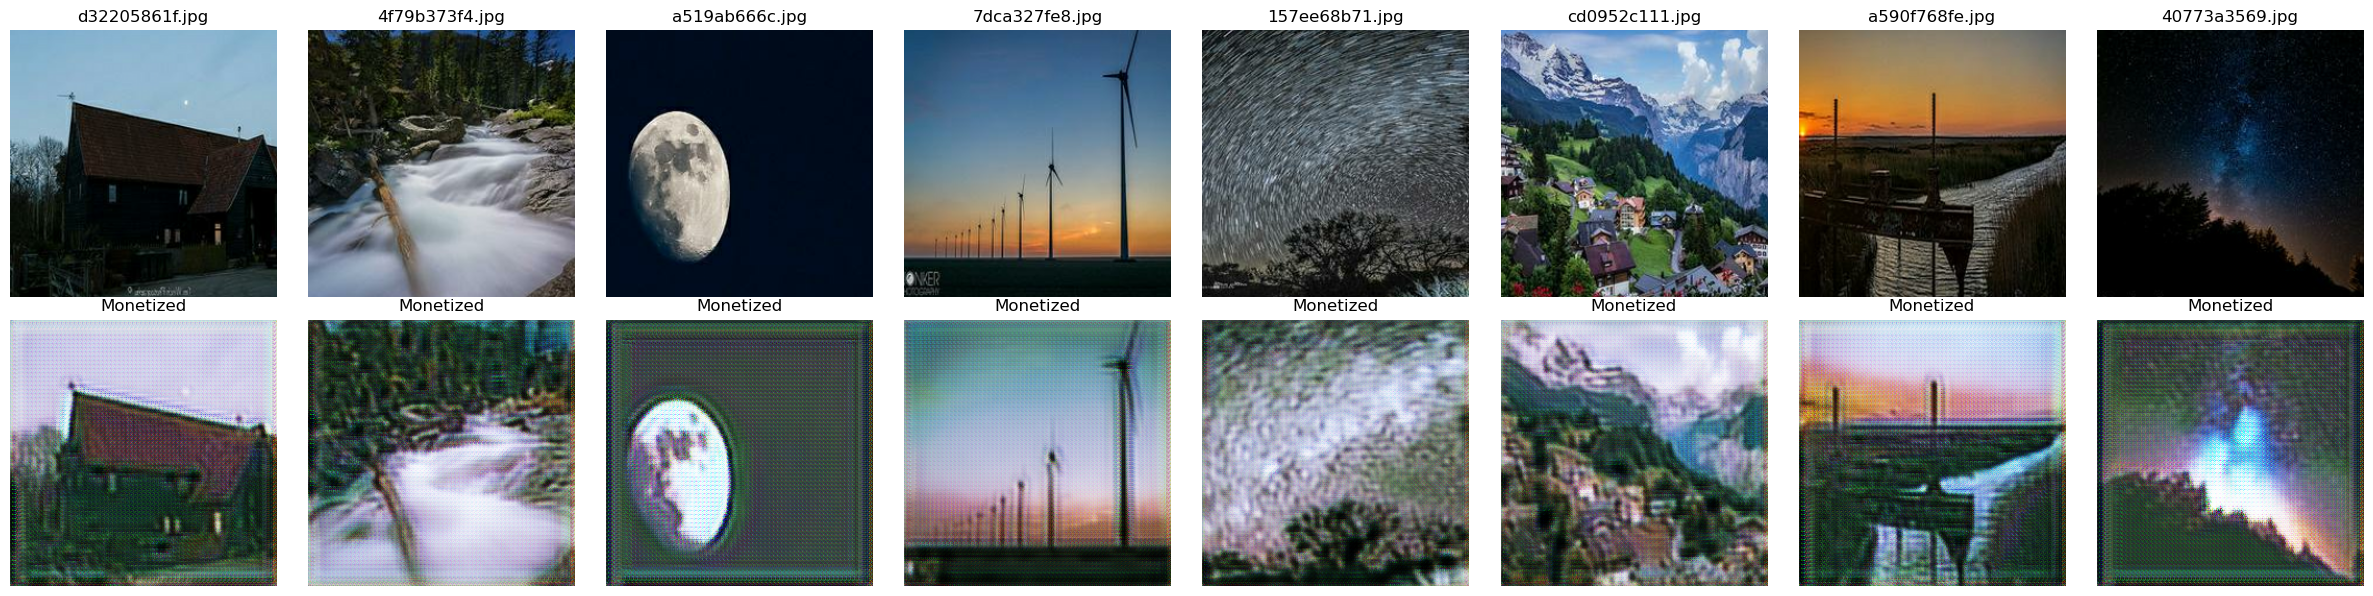

In [19]:


# === run inference on a few photos and show side-by-side ===
import random, matplotlib.pyplot as plt, os, numpy as np, tensorflow as tf

PREVIEW_DIR = "./outputs/preview_grid"
os.makedirs(PREVIEW_DIR, exist_ok=True)

def denorm(x):
    """[-1,1] tensor -> uint8 numpy"""
    x = tf.clip_by_value((x + 1.0) * 127.5, 0, 255)
    return tf.cast(x, tf.uint8).numpy()

# pick N random photos
N = 8
all_files = tf.io.gfile.listdir(photo_jpg_path)
files = random.sample(all_files, N)

# run generator and collect pairs
orig_list, gen_list = [], []
for f in files:
    x = decode_resize_norm(os.path.join(photo_jpg_path, f))[None]  # (1,H,W,3) in [-1,1]
    y = G_XY(x, training=False)
    orig_list.append(denorm(x[0]))
    gen_list.append(denorm(y[0]))

# plot 2 x N grid: top originals, bottom generated
plt.figure(figsize=(3*N, 6))
for i in range(N):
    # originals row
    plt.subplot(2, N, i+1)
    plt.imshow(orig_list[i])
    plt.title(os.path.basename(files[i]))
    plt.axis("off")
    # generated row
    plt.subplot(2, N, N+i+1)
    plt.imshow(gen_list[i])
    plt.title("Monetized")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# ==== Fast export a small sample and zip ====
import os, glob, zipfile, random
import tensorflow as tf

EXPORT_DIR = "./outputs/images"
os.makedirs(EXPORT_DIR, exist_ok=True)

# deterministic [-1,1] preprocess for inference (no flip/jitter)
def decode_for_infer(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method='bicubic')
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

def to_uint8(x):
    return tf.cast(tf.clip_by_value((x + 1.0) * 127.5, 0, 255), tf.uint8)

def export_some_photos(n=40, batch=8, in_dir=photo_jpg_path, out_dir=EXPORT_DIR, seed=123):
    # clear old images to avoid counting previous runs
    for p in glob.glob(os.path.join(out_dir, "*.jpg")):
        try: os.remove(p)
        except: pass

    files = tf.io.gfile.listdir(in_dir)
    if not files:
        raise RuntimeError(f"No files found in {in_dir}")
    random.seed(seed)
    files = random.sample(files, min(n, len(files)))
    fpaths = [os.path.join(in_dir, f) for f in files]

    # build small batched dataset
    ds = (tf.data.Dataset.from_tensor_slices(fpaths)
          .map(decode_for_infer, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch))

    idx = 0
    for xb in ds:
        yb = G_XY(xb, training=False)                         # model inference
        yb = tf.image.resize(to_uint8(yb), (256, 256))        # save at 256x256
        for k in range(yb.shape[0]):
            tf.keras.utils.save_img(os.path.join(out_dir, f"{idx}.jpg"), yb[k])
            idx += 1
    print(f"Exported {idx} images -> {out_dir}")

def zip_dir(src=EXPORT_DIR, zip_path="./outputs/images_part.zip"):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for p in sorted(glob.glob(os.path.join(src, "*.jpg"))):
            zf.write(p, arcname=os.path.basename(p))
    print("Created:", zip_path)


export_some_photos(n=1000, batch=8)
zip_dir()
